In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if does not
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**GET DATA**

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

**DATASETS == DATALOADERS**

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE,
)
len(train_dataloader), test_dataloader, class_names

(8,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# visualize single image
img, label = next(iter(train_dataloader))
# Display the image
# plt.imshow(img) # ERROR: C H W vs H W C
# plt.axis('off')  # Optional: Turn off axes for better visualization
# plt.show()
img[0], label[0]

(tensor([[[0.0784, 0.0784, 0.0824,  ..., 0.9373, 0.9333, 0.9255],
          [0.0784, 0.0824, 0.0745,  ..., 0.9686, 0.9608, 0.9529],
          [0.0784, 0.0745, 0.0745,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.6275, 0.6039, 0.6078,  ..., 0.7804, 0.7725, 0.7647],
          [0.6353, 0.6235, 0.6196,  ..., 0.7529, 0.7373, 0.7294],
          [0.6431, 0.6314, 0.6510,  ..., 0.7529, 0.7294, 0.7255]],
 
         [[0.0706, 0.0706, 0.0706,  ..., 0.9059, 0.8980, 0.8941],
          [0.0706, 0.0706, 0.0627,  ..., 0.9490, 0.9412, 0.9333],
          [0.0706, 0.0627, 0.0627,  ..., 0.9922, 0.9882, 0.9882],
          ...,
          [0.1216, 0.0863, 0.0902,  ..., 0.6902, 0.6824, 0.6784],
          [0.1373, 0.1137, 0.1059,  ..., 0.6667, 0.6510, 0.6431],
          [0.1529, 0.1255, 0.1451,  ..., 0.6667, 0.6431, 0.6392]],
 
         [[0.0902, 0.0941, 0.0980,  ..., 0.9059, 0.9020, 0.8980],
          [0.0902, 0.0941, 0.0902,  ..., 0.9529, 0.9412, 0.9333],
          [0.0902, 0.0863, 0.0902,  ...,

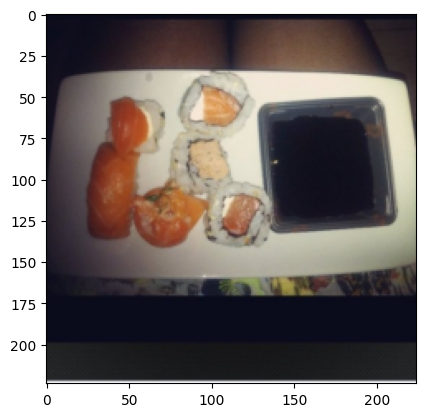

In [ ]:
import torchvision.transforms as T

# Assuming img is a tensor in the form [C, H, W] (channel-first)
# Convert it to a NumPy array in [H, W, C] format
img_np = T.ToPILImage()(img[0]).convert("RGB")
# img_np = img[0].permute(1,2,0)
plt.imshow(img_np)

# **4. EQUATION 1**

In [ ]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


# 4.2 Turning a single image into patches

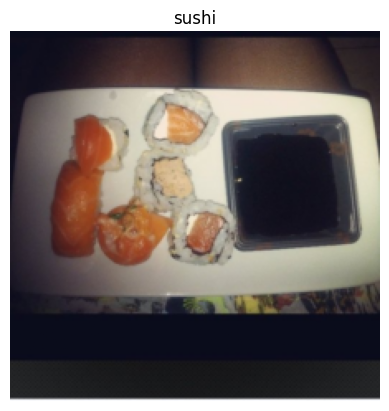

In [ ]:
# View single img
import matplotlib.pyplot as plt
image = img[0]
label = label[0]
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

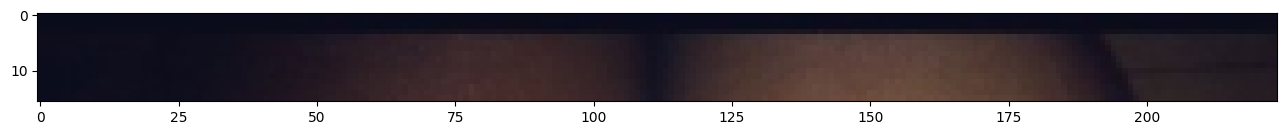

In [ ]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels
0: 0
1: 16
2: 32
3: 48
4: 64
5: 80
6: 96
7: 112
8: 128
9: 144
10: 160
11: 176
12: 192
13: 208


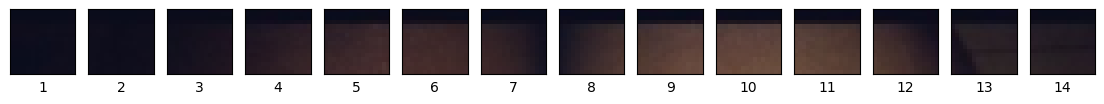

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    print(f"{i}: {patch}")
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


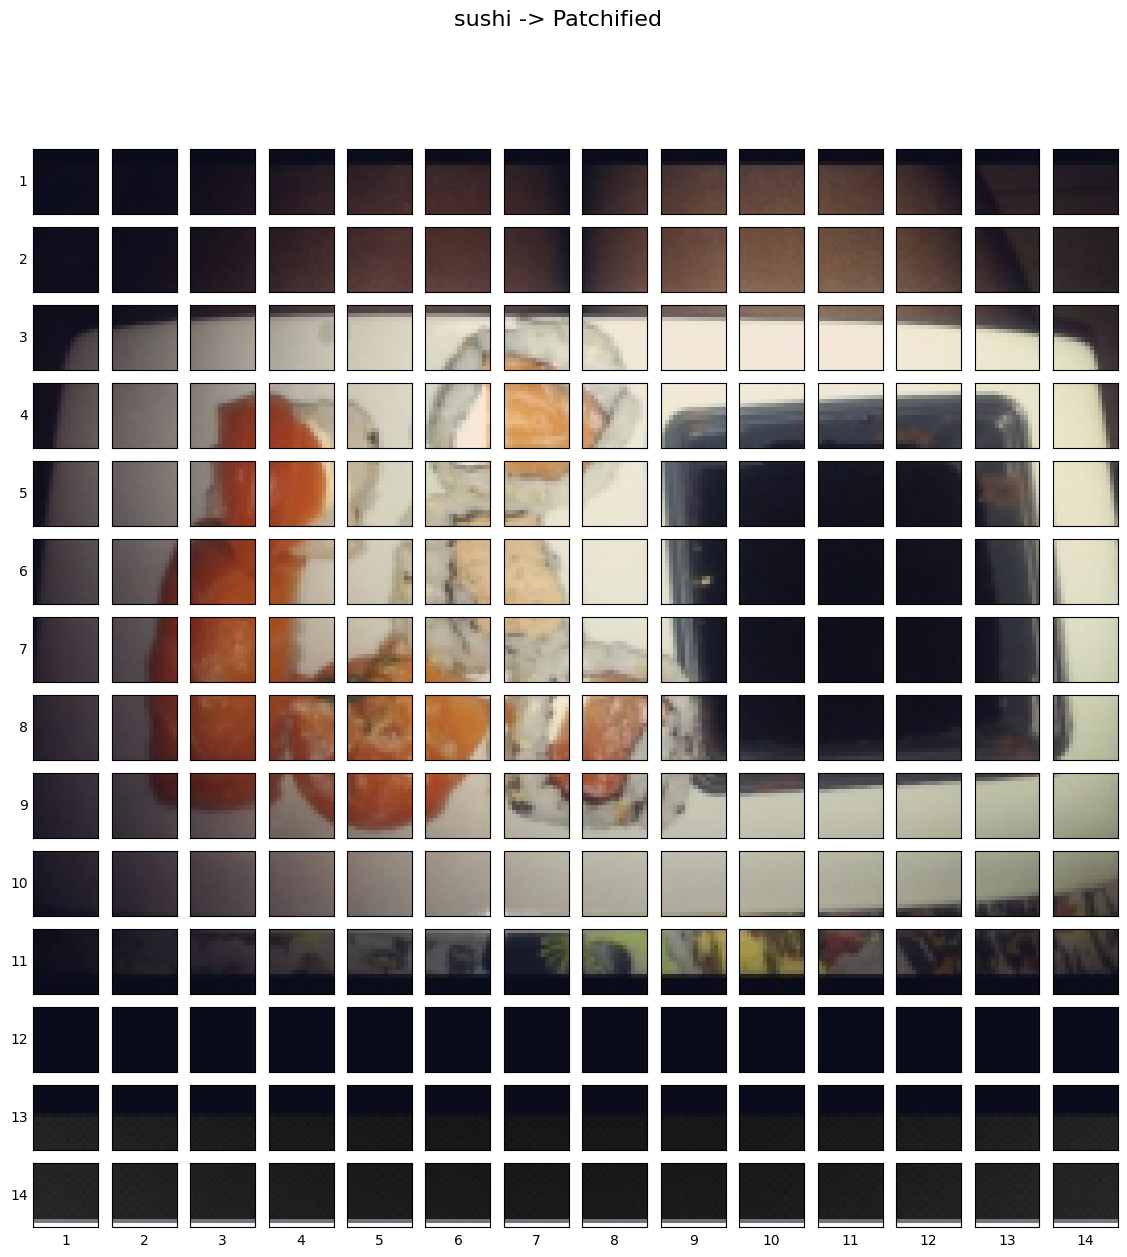

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

# **4.3 Conv2d**

In [ ]:
from torch import nn
patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

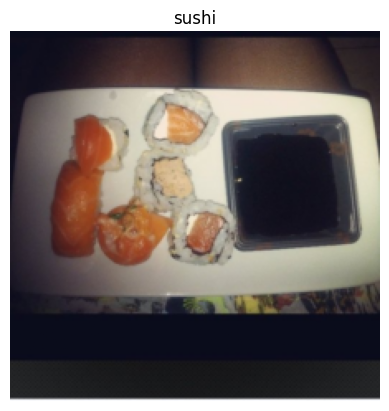

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [ ]:
output_conv_image = conv2d(image.unsqueeze(dim=0))
print(f"Output shape: {output_conv_image.shape}")
# print(output.shape)
# output

Output shape: torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [753, 200, 509, 717, 349]


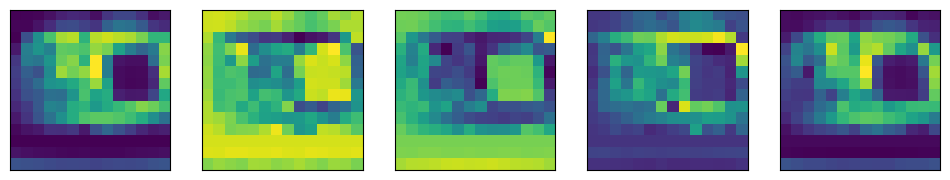

In [ ]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = output_conv_image[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

# **4.4 Flattening**

In [ ]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


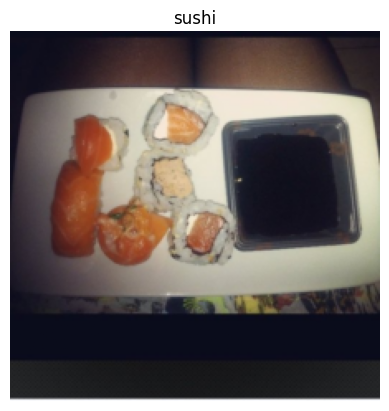

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


**We've now matched the desired input and output shapes for the patch embedding layer of the ViT architecture using a couple of PyTorch layers.**

How about we visualize one of the flattened feature maps?

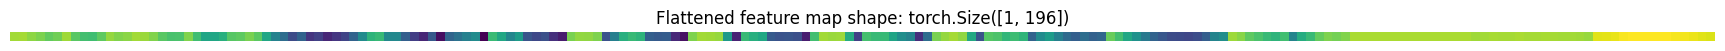

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-7.7418e-02, -7.5167e-02, -9.4880e-02, -1.1297e-01, -1.3718e-01,
          -1.2405e-01, -7.8469e-02, -1.4654e-01, -1.7403e-01, -1.7856e-01,
          -1.4170e-01, -8.9904e-02, -1.0815e-01, -9.7207e-02, -7.7502e-02,
          -8.5266e-02, -1.0720e-01, -1.4797e-01, -1.6581e-01, -1.6419e-01,
          -1.0809e-01, -1.7650e-01, -2.3968e-01, -2.3718e-01, -2.1505e-01,
          -1.4844e-01, -1.4213e-01, -1.1363e-01, -1.4533e-01, -2.3719e-01,
          -3.2676e-01, -3.7844e-01, -4.5226e-01, -4.0255e-01, -5.0079e-01,
          -4.7668e-01, -5.2518e-01, -4.9670e-01, -4.7028e-01, -4.0187e-01,
          -3.0376e-01, -2.0339e-01, -1.8956e-01, -3.1416e-01, -3.1313e-01,
          -4.1130e-01, -4.8237e-01, -5.2769e-01, -4.2611e-01, -5.7109e-01,
          -3.9724e-01, -3.6723e-01, -3.3068e-01, -3.0263e-01, -5.9215e-01,
          -1.8384e-01, -2.3280e-01, -3.1667e-01, -2.6141e-01, -4.3394e-01,
          -4.6263e-01, -4.4533e-01, -5.0974e-01, -5.4494e-01, -1.1467e-01,
          -9.1003e-02, -9

# **4.5 Turning the ViT patch embedding layer into a PyTorch module**

Specifically we'll:

1.   Create a class called PatchEmbedding which subclasses nn.Module (so it can be used a PyTorch layer).
2.   Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using nn.Conv2d() (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).
5. Define a forward() method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture
(${N \times\left(P^{2} \cdot C\right)}$)






In [ ]:

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
    '''
    This class implements the Patch Embedding layer for Vision Transformers (ViT).
    It splits an input image into non-overlapping patches, projects them into an
    embedding space using a convolutional layer, and prepares the patch embeddings
    for further processing in a transformer model.

    Attributes:
    - in_channels (int): Number of input channels in the image (e.g., 3 for RGB).
    - patch_size (int): Size of each patch (height and width are equal).
    - embedding_dim (int): Dimension of the patch embedding.

    Methods:
    - __init__: Initializes the patch embedding layer.
    - forward: Performs the patch embedding process on the input image.
    '''
    super().__init__()
    self.patch_size = patch_size
    self.conv2d_layer = nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, input):
    # Create assertion to check that inputs are the correct shape
    image_resolution = input.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    image = input
    # print(f"[INFO] Image shape {image.shape}")
    temp = self.conv2d_layer(image) # they must input with batch size suffix
    # print(f"[INFO] AFTER CONV shape {temp.shape}")
    temp2 = self.flatten(temp)
    # print(f"[INFO] final shape {temp2.shape}")
    temp3 = temp2.permute(0,2,1)
    return temp3

In [ ]:
model = PatchEmbedding()
model

PatchEmbedding(
  (conv2d_layer): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=2, end_dim=3)
)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])
------ with Model --------
Flattened image feature map shape: torch.Size([1, 196, 768])


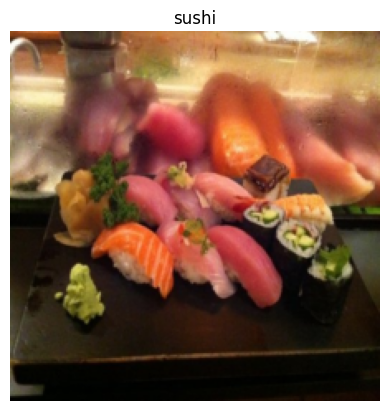

In [ ]:
img, label = next(iter(train_dataloader))

# View single img
import matplotlib.pyplot as plt

image = img[1]
label = label[1]
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(dim=0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


print(f"------ with Model --------")

# 2. Turn image into feature maps
image_out_of_model = model(image.unsqueeze(0))
print(f"Flattened image feature map shape: {image_out_of_model.shape}")

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
# Create random input sizes
# random_input_image = (1, 3, 224, 224)
random_input_image = (1, 3, 224, 224)
# random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (conv2d_layer)                  [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

# **4.6 Creating the class token embedding**

In [ ]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.6077,  0.0998, -0.2119,  ...,  0.2178, -0.0951,  0.4495],
         [-0.2809, -0.0452, -0.1044,  ...,  0.2834, -0.1825,  0.2061],
         [-0.1838,  0.0200, -0.1153,  ...,  0.1418, -0.1440,  0.1930],
         ...,
         [-0.0685, -0.0220, -0.0357,  ...,  0.0306, -0.0309,  0.0309],
         [-0.0634, -0.0162, -0.0335,  ...,  0.0434, -0.0312,  0.0227],
         [-0.0686, -0.0093, -0.0276,  ...,  0.0454, -0.0342,  0.0257]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(data=torch.randn(1,1,768), requires_grad=True)
# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[-2.4663,  0.4867,  0.8128,  0.3298, -1.6121, -0.5759, -0.2281,
           0.2943,  0.1197,  1.5855]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-2.4663,  0.4867,  0.8128,  ...,  0.9203,  0.2370,  1.4758],
         [-0.6077,  0.0998, -0.2119,  ...,  0.2178, -0.0951,  0.4495],
         [-0.2809, -0.0452, -0.1044,  ...,  0.2834, -0.1825,  0.2061],
         ...,
         [-0.0685, -0.0220, -0.0357,  ...,  0.0306, -0.0309,  0.0309],
         [-0.0634, -0.0162, -0.0335,  ...,  0.0434, -0.0312,  0.0227],
         [-0.0686, -0.0093, -0.0276,  ...,  0.0454, -0.0342,  0.0257]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# **4.7 Creating the position embedding**

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-7.4114e-01,  8.1541e-01, -3.6316e-01,  1.0176e+00,  4.5293e-01,
           9.5421e-01, -1.9018e+00,  9.4062e-02, -1.0380e+00,  8.5705e-01],
         [-6.3292e-01,  6.0168e-01,  7.7370e-01, -6.4148e-01, -1.5129e-02,
          -7.0166e-01, -5.5823e-01,  1.1979e+00,  1.0343e+00, -8.0253e-01],
         [ 4.1812e-01, -8.0315e-01,  6.8380e-01, -6.9289e-01, -3.1867e-01,
          -1.1738e+00, -2.0773e+00,  8.2932e-02, -4.8459e-01,  5.6662e-01],
         [ 9.8222e-01, -2.8216e-01, -8.5354e-01,  9.9346e-02,  4.3550e-02,
           2.0549e-01,  1.7851e+00,  5.2269e-02,  2.8783e-01,  1.2212e+00],
         [ 3.9332e-01, -4.4542e-01, -1.1296e+00,  2.9640e-01,  1.2835e+00,
          -4.3154e-01, -3.4652e-01,  3.9845e+00,  1.7684e+00, -2.0047e-01],
         [-1.0939e+00,  6.1262e-01, -6.9854e-02, -2.3281e-01,  8.0949e-04,
           4.6305e-02, -3.4145e-01, -6.8767e-01, -9.8743e-01,  2.3791e+00],
         [-1.5328e+00, -7.9215e-01, -5.5720e-01,  1.0095e+00, -6.4669e-01,
          -1.2823e+

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-3.2074,  1.3021,  0.4496,  ...,  2.0919, -0.4471, -0.3826],
         [-1.2407,  0.7015,  0.5618,  ..., -0.2128, -1.2712,  0.9535],
         [ 0.1372, -0.8483,  0.5794,  ...,  0.1779,  1.0255, -0.9614],
         ...,
         [-0.2689, -2.7510, -0.5250,  ..., -1.6754,  0.1356,  1.2895],
         [ 0.3704,  0.1865,  0.7377,  ..., -0.2065, -0.7167, -0.0111],
         [-1.8075,  0.7477, -1.0657,  ..., -1.5529, -0.1891,  0.4830]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# **4.8 Putting it all together: from image to embedding**


# **5. Equation 2: Multi-Head Attention (MSA)**


1.   Create a class called MultiheadSelfAttentionBlock that inherits from torch.nn.Module.
2.   Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate embed_dim, num_heads, dropout and batch_first parameters.
5. Create a forward() method for our class passing the in the inputs through the LN layer and MSA layer.



# **5.3 Replicating Equation 2 with PyTorch layers**

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
    A Multi-Head Self-Attention Block for processing input sequences using multi-head attention.

    Attributes:
        attention_layer (nn.MultiheadAttention):
            A PyTorch multi-head attention layer that performs the self-attention mechanism
            with a specified embedding dimension, number of attention heads, and dropout rate.
        layer_norm (nn.LayerNorm):
            A layer normalization module that normalizes input data across the embedding dimension
            to stabilize and improve learning.

    Args:
        num_heads (int):
            The number of attention heads to use. Each head processes the input in parallel
            with its own attention mechanism. Default is 12.
        attn_dropout (float):
            Dropout rate for attention weights to improve regularization. Default is 0.
        embedding_dim (int):
            Dimensionality of the input embedding. Must be divisible by the number of attention heads.
            Default is 768.

    Methods:
        forward(input):
            Processes the input tensor through the attention block, normalizing it, computing
            self-attention, and returning the attention output.

            Args:
                input (torch.Tensor):
                    The input tensor of shape `(batch_size, sequence_length, embedding_dim)`.

            Returns:
                torch.Tensor:
                    The attention output of shape `(batch_size, sequence_length, embedding_dim)`.
  """
  def __init__(self, num_heads=12, attn_dropout=0, embedding_dim=768):
    super().__init__()

    self.attention_layer = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

  def forward(self, input):
    tmp = self.layer_norm(input)
    query, key, value = tmp, tmp, tmp
    attn_output, _ = self.attention_layer(query, key, value, need_weights=False)
    return attn_output

In [ ]:
msa_model = MultiHeadSelfAttentionBlock()
res = msa_model(patch_and_position_embedding)
print(f"Result shape: {res.shape}")
patched_image_through_msa_block = res

Result shape: torch.Size([1, 197, 768])


In [ ]:
res == patch_and_position_embedding

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

# **6. Equation 3: Multilayer Perceptron (MLP)**

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """
    A Layer Normalized Multi-Layer Perceptron (MLP) Block for processing input embeddings.

    Attributes:
        layer_norm (nn.LayerNorm):
            A layer normalization module applied to the input tensor to stabilize and enhance learning.
        mlp (nn.Sequential):
            A sequential module containing two linear layers with GELU activation and dropout
            applied after each dense layer.

    Args:
        embedding_dim (int):
            Dimensionality of the input and output embedding. Default is 768 (ViT-Base Hidden Size D).
        mlp_size (int):
            Dimensionality of the intermediate layer in the MLP. Default is 3072 (ViT-Base MLP size).
        dropout (float):
            Dropout rate applied after each dense layer in the MLP to improve regularization. Default is 0.1.

    Methods:
        forward(x):
            Processes the input tensor through the layer normalization and MLP layers.

            Args:
                x (torch.Tensor):
                    The input tensor of shape `(batch_size, sequence_length, embedding_dim)`.

            Returns:
                torch.Tensor:
                    The output tensor of shape `(batch_size, sequence_length, embedding_dim)`,
                    with the same dimensionality as the input embedding.
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])



# **7. Create the Transformer Encoder**

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """
    A Transformer Encoder Block combining Multi-Head Self-Attention (MSA) and Multi-Layer Perceptron (MLP) blocks,
    with residual connections for both.

    Attributes:
        msa_block (MultiHeadSelfAttentionBlock):
            A multi-head self-attention block implementing scaled dot-product attention with residual connections.
        mlp_block (MLPBlock):
            A multilayer perceptron block with two dense layers, GELU activation, dropout, and residual connections.

    Args:
        embedding_dim (int):
            Dimensionality of the input embeddings. Default is 768 (ViT-Base Hidden Size D).
        num_heads (int):
            Number of attention heads in the MSA block. Default is 12 (ViT-Base number of heads).
        mlp_size (int):
            Dimensionality of the intermediate layer in the MLP block. Default is 3072 (ViT-Base MLP size).
        mlp_dropout (float):
            Dropout rate for dense layers in the MLP block. Default is 0.1.
        attn_dropout (float):
            Dropout rate for the attention layers in the MSA block. Default is 0.

    Methods:
        forward(x):
            Passes the input tensor through the MSA block and MLP block, applying residual connections.

            Args:
                x (torch.Tensor):
                    Input tensor of shape `(batch_size, sequence_length, embedding_dim)`.

            Returns:
                torch.Tensor:
                    Output tensor of shape `(batch_size, sequence_length, embedding_dim)`
                    with updated embeddings after attention and MLP transformations.
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (attention_layer)        [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             


# **8. Putting it all together to create ViT**

In [ ]:
class ViT_Custom(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels:int = 3,
               out_channels:int = 768,
               patch_size:int = 16,
               num_transformer_layers:int = 12,
               embedding_dim:int =768,
               mlp_size:int = 3072,
               num_heads:int = 12,
               attn_dropout:float = 0,
               mlp_dropout:float = 0.1,
               embedding_dropout:float = 0.1,
               num_classes:int = 1000):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

    self.num_patches = (img_size*img_size)//(patch_size*patch_size)
    # print(f"Number of patches {self.num_patches}")

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                           num_heads=num_heads,
                                                           mlp_size=mlp_size,
                                                           mlp_dropout=mlp_dropout,
                                                           attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes),
    )

  def forward(self, x):

    batch_size = x.shape[0]

    class_token = self.class_embedding.expand(batch_size, -1, -1)

    patch = self.patch_embedding(x)

    transformer_input = torch.cat((class_token, patch), dim=1) + self.position_embedding

    transformer_input = self.embedding_dropout(transformer_input)

    transformer_output = self.transformer_encoder(transformer_input)

    x = self.classifier(transformer_output[:, 0])

    return x


In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

testing expand

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT_Custom(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [ ]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT_Custom (ViT_Custom)                                      [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (conv2d_layer)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]


# **9. Setting up training code for our ViT model**

In [ ]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=1,
                       device=device)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

# **Using a pretrained ViT from torchvision.models on the same dataset**

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights2 = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit2 = torchvision.models.vit_b_16(weights=pretrained_vit_weights2).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit2.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
# pretrained_vit2.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit2,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  False
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 19

In [ ]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


**Train feature extractor ViT model**

In [ ]:
pretrained_vit.parameters()

<generator object Module.parameters at 0x7fe97f7de340>

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
# so betas and weight_decay baked into it?
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


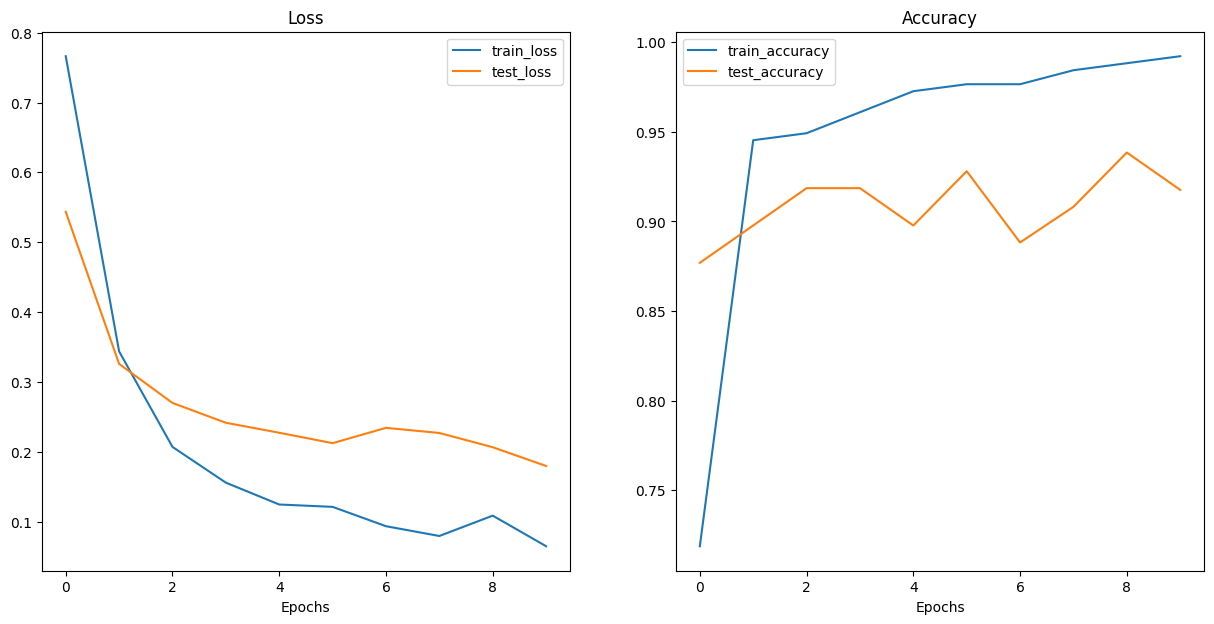

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


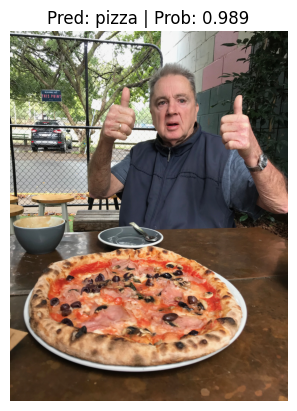

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
img[0]

tensor([[[0.0784, 0.0784, 0.0824,  ..., 0.9373, 0.9333, 0.9255],
         [0.0784, 0.0824, 0.0745,  ..., 0.9686, 0.9608, 0.9529],
         [0.0784, 0.0745, 0.0745,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.6275, 0.6039, 0.6078,  ..., 0.7804, 0.7725, 0.7647],
         [0.6353, 0.6235, 0.6196,  ..., 0.7529, 0.7373, 0.7294],
         [0.6431, 0.6314, 0.6510,  ..., 0.7529, 0.7294, 0.7255]],

        [[0.0706, 0.0706, 0.0706,  ..., 0.9059, 0.8980, 0.8941],
         [0.0706, 0.0706, 0.0627,  ..., 0.9490, 0.9412, 0.9333],
         [0.0706, 0.0627, 0.0627,  ..., 0.9922, 0.9882, 0.9882],
         ...,
         [0.1216, 0.0863, 0.0902,  ..., 0.6902, 0.6824, 0.6784],
         [0.1373, 0.1137, 0.1059,  ..., 0.6667, 0.6510, 0.6431],
         [0.1529, 0.1255, 0.1451,  ..., 0.6667, 0.6431, 0.6392]],

        [[0.0902, 0.0941, 0.0980,  ..., 0.9059, 0.9020, 0.8980],
         [0.0902, 0.0941, 0.0902,  ..., 0.9529, 0.9412, 0.9333],
         [0.0902, 0.0863, 0.0902,  ..., 0.9961, 0.9922, 0.

In [ ]:
# pretrained_vit()

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 5.9.1


In [ ]:
pretrained_vit.to('cpu')

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
from typing import Tuple, Dict
import timeit
import time

def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    # start_time = timer()
    start_time = timeit.default_timer() # for this line to work you need to uncomment and run line 2

    # Transform the target image and add a batch dimension
    img = pretrained_vit_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    pretrained_vit.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(pretrained_vit(img), dim=1)
        print(f"pred_probs: {pred_probs} - {pred_probs.shape}")

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    # pred_time = round(timer() - start_time, 5)
    pred_time = round(timeit.default_timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi/test/steak/673127.jpg

pred_probs: tensor([[6.1949e-04, 9.9087e-01, 8.5125e-03]]) - torch.Size([1, 3])
Prediction label and probability dictionary: 
{'pizza': 0.0006194933084771037, 'steak': 0.9908679723739624, 'sushi': 0.008512498810887337}
Prediction time: 0.37635 seconds


In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi/test/pizza/3092704.jpg'],
 ['data/pizza_steak_sushi/test/steak/296375.jpg'],
 ['data/pizza_steak_sushi/test/pizza/2003290.jpg']]

# **Building a Gradio interface**

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "Food Classifier 🍕🥩🍣"
description = "An ViT feature extractor computer vision model to classify images of food as pizza, steak or sushi."
# article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    # article=article
                    )

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5afe731e9e675ed5fe.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr

# Create title, description and article strings
title = "Food Classifier 🍕🥩🍣"
description = "An ViT feature extractor computer vision model to classify images of food as pizza, steak or sushi."
# article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    # article=article
                    )

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://68a17b07d93af095fa.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **create project structure**

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
food_classifier_demo_path = Path("demos/food_classifier_mini/")

# Remove files that might already exist there and create new directory
if food_classifier_demo_path.exists():
    shutil.rmtree(food_classifier_demo_path)
# If the file doesn't exist, create it anyway
food_classifier_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Check what's in the folder
!ls demos/foodvision_mini/

ls: cannot access 'demos/foodvision_mini/': No such file or directory


In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
food_classifier_examples_path = food_classifier_demo_path / "examples"
food_classifier_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
                            Path('data/pizza_steak_sushi/test/steak/100274.jpg'),
                            Path('data/pizza_steak_sushi/test/sushi/1172255.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = food_classifier_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi/test/pizza/1152100.jpg to demos/food_classifier_mini/examples/1152100.jpg
[INFO] Copying data/pizza_steak_sushi/test/steak/100274.jpg to demos/food_classifier_mini/examples/100274.jpg
[INFO] Copying data/pizza_steak_sushi/test/sushi/1172255.jpg to demos/food_classifier_mini/examples/1172255.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(food_classifier_examples_path)]
example_list

[['examples/100274.jpg'], ['examples/1172255.jpg'], ['examples/1152100.jpg']]

In [ ]:
import shutil

# Create a source path for our target model
pretrained_vit_food_classifier_model_path = "models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth"

# Create a destination path for our target model
pretrained_vit_food_classifier_model_destination = food_classifier_demo_path / pretrained_vit_food_classifier_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {pretrained_vit_food_classifier_model_path} to {pretrained_vit_food_classifier_model_destination}")

    # Move the model
    shutil.move(src=pretrained_vit_food_classifier_model_path,
                dst=pretrained_vit_food_classifier_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {pretrained_vit_food_classifier_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {pretrained_vit_food_classifier_model_destination}: {pretrained_vit_food_classifier_model_destination.exists()}")

[INFO] Attempting to move models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth to demos/food_classifier_mini/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth
[INFO] Model move complete.


In [ ]:
%%writefile demos/food_classifier_mini/model.py
import torch
import torchvision

from torch import nn


def create_pretrained_vit_model(num_classes:int=3,
                          seed:int=42):
    """Creates an Pretrained ViT feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): pretrained_vit feature extractor model.
        transforms (torchvision.transforms): pretrained_vit image transforms.
    """
    # Create pretrained_vit pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/food_classifier_mini/model.py


In [ ]:
%%writefile demos/food_classifier_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_pretrained_vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
pretrained_vit, pretrained_vit_transforms = create_pretrained_vit_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
pretrained_vit.load_state_dict(
    torch.load(
        f="09_pretrained_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = pretrained_vit_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    pretrained_vit.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(pretrained_vit(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Food Classifier 🍕🥩🍣"
description = "A Vision Transformer feature extractor computer vision model to classify images of food as pizza, steak or sushi."
# article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    # article=article
                    )

# Launch the demo!
demo.launch()

Writing demos/food_classifier_mini/app.py


In [ ]:
%%writefile demos/food_classifier_mini/requirements.txt
torch==2.5.1
torchvision==0.20.1
gradio==3.1.4

Overwriting demos/food_classifier_mini/requirements.txt


In [ ]:
!ls demos/food_classifier_mini

08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth  examples  requirements.txt
app.py							   model.py


In [ ]:
!zip -r ../food_classifier_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

updating: data/ (stored 0%)
updating: data/pizza_steak_sushi/ (stored 0%)
updating: data/pizza_steak_sushi/train/ (stored 0%)
updating: data/pizza_steak_sushi/train/sushi/ (stored 0%)
updating: data/pizza_steak_sushi/train/sushi/3107839.jpg (deflated 0%)
updating: data/pizza_steak_sushi/train/sushi/3004029.jpg (deflated 0%)
updating: data/pizza_steak_sushi/train/sushi/377047.jpg (deflated 0%)
updating: data/pizza_steak_sushi/train/sushi/3353428.jpg (deflated 0%)
updating: data/pizza_steak_sushi/train/sushi/385154.jpg (deflated 0%)
updating: data/pizza_steak_sushi/train/sushi/1575445.jpg (deflated 0%)
updating: data/pizza_steak_sushi/train/sushi/3251688.jpg (deflated 1%)
updating: data/pizza_steak_sushi/train/sushi/748830.jpg (deflated 1%)
updating: data/pizza_steak_sushi/train/sushi/765684.jpg (deflated 0%)
updating: data/pizza_steak_sushi/train/sushi/2641778.jpg (deflated 1%)
updating: data/pizza_steak_sushi/train/sushi/3081701.jpg (deflated 1%)
updating: data/pizza_steak_sushi/train/

In [ ]:
# # Change into and then zip the foodvision_mini folder but exclude certain files
# !cd demos/food_classifier_mini && zip -r ../food_classifier_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# # Download the zipped FoodVision Mini app (if running in Google Colab)
# try:
#     from google.colab import files
#     files.download("demos/food_classifier_mini.zip")
# except:
#     print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: 08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth (deflated 7%)
  adding: app.py (deflated 58%)
  adding: examples/ (stored 0%)
  adding: examples/100274.jpg (deflated 1%)
  adding: examples/1172255.jpg (deflated 0%)
  adding: examples/1152100.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # Change into and then zip the foodvision_mini folder but exclude certain files
# !cd demos/food_classifier_mini && zip -r ../food_classifier_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# # Download the zipped FoodVision Mini app (if running in Google Colab)
# try:
#     from google.colab import files
#     files.download("demos/food_classifier_mini.zip")
# except:
#     print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

updating: 08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth (deflated 7%)
updating: app.py (deflated 58%)
updating: examples/ (stored 0%)
updating: examples/100274.jpg (deflated 1%)
updating: examples/1172255.jpg (deflated 0%)
updating: examples/1152100.jpg (deflated 0%)
updating: model.py (deflated 56%)
updating: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
1==12

In [ ]:
# from huggingface_hub import (
#     create_repo,
#     get_full_repo_name,
#     upload_file,
#     upload_folder
# )

# LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "../demo/food_not_food_text_classification"
# HF_TARGET_SPACE_NAME = "learn_hf_food_not_food_text_classifier_demo"
# HF_REPO_TYPE = "space"
# HF_SPACE_SDK = "gradio"
# # HF_TOKEN = ""


# print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
# create_repo(
#     repo_id=HF_TARGET_SPACE_NAME,
#     repo_type=HF_REPO_TYPE,
#     private=False,
#     space_sdk=HF_SPACE_SDK,
#     exist_ok=True,
# )

# full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
# print("[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
# folder_upload_url = upload_folder(
#     repo_id = full_hf_repo_name,
#     folder_path = LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
#     path_in_repo = ".",
#     repo_type = HF_REPO_TYPE,
#     commit_message = "Uploading food not food text classifier demo.py"
# )

# print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")


# 1. Import the required methods for uploading to the Hugging Face Hub
import os
from huggingface_hub import (
    login,
    create_repo,
    get_full_repo_name,
    upload_file, # for uploading a single file (if necessary)
    upload_folder # for uploading multiple files (in a folder)
)

# 2. Define the parameters we'd like to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "/content/demos/food_classifier_mini"
HF_TARGET_SPACE_NAME = "ViT_Food_Classifier_miniature"
HF_REPO_TYPE = "space" # we're creating a Hugging Face Space
HF_SPACE_SDK = "gradio"

from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN_MASTER')
print(f"[INFO] HF TOKEN {HF_TOKEN}")
# HF_TOKEN = "" # optional: set to your Hugging Face token (but I'd advise storing this as an environment variable as previously discussed)


login(token=HF_TOKEN)
# 3. Create a Space repository on Hugging Face Hub
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    token=HF_TOKEN, # optional: set token manually (though it will be automatically recognized if it's available as an environment variable)
    repo_type=HF_REPO_TYPE,
    private=False, # set to True if you don't want your Space to be accessible to others
    space_sdk=HF_SPACE_SDK,
    exist_ok=True, # set to False if you want an error to raise if the repo_id already exists
)

# 4. Get the full repository name (e.g. {username}/{model_id} or {username}/{space_name})
full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # upload our folder to the root directory ("." means "base" or "root", this is the default)
    # token=HF_TOKEN, # optional: set token manually
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading food classifier demo app.py"
)
print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

TimeoutException: Requesting secret HF_TOKEN_MASTER timed out. Secrets can only be fetched when running from the Colab UI.